In [68]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import torch.optim as optim
from tqdm import tqdm





In [ ]:
DATASET_PATH = "cifar10_images"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = ImageFolder(root="/home/rajdeep/UMC203project/cifar10_images/train", transform=transform)
test_dataset = ImageFolder(root="/home/rajdeep/UMC203project/cifar10_images/test", transform=transform)

In [23]:
Train,labels = [], []
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    Train.append(img)
    labels.append(label)
train_images = torch.stack(Train)
train_labels = torch.tensor(labels)

In [24]:
Train,labels = [], []
for i in range(len(test_dataset)):
    img, label = train_dataset[i]
    Train.append(img)
    labels.append(label)
test_images = torch.stack(Train)
test_labels = torch.tensor(labels)

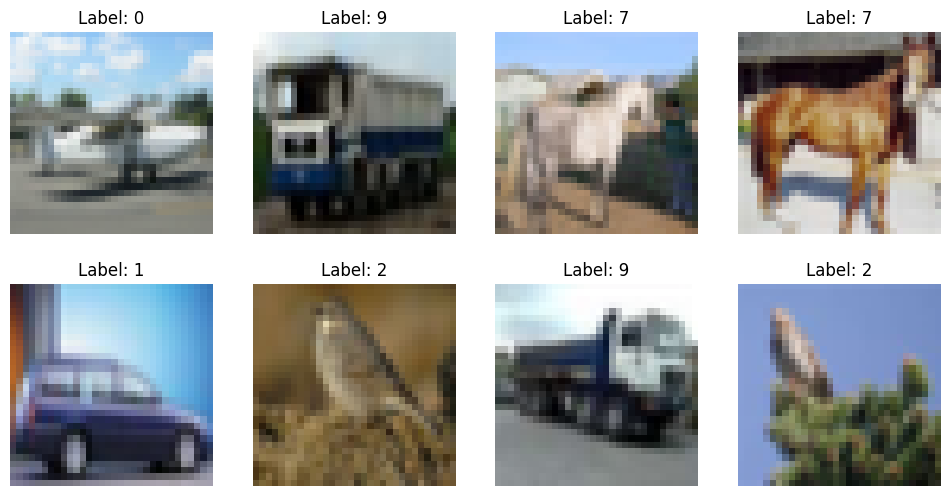

In [37]:
#to print 8 random images
def show_random_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[idx].permute(1, 2, 0) / 2 + 0.5)
        plt.title(f"Label: {labels[idx]}")
        plt.axis("off")
    plt.show()
show_random_images(train_images, train_labels)
    


In [ ]:
patch_size = 4
stride = 4
train_patches = train_images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
train_patches = train_patches.permute(0, 2, 3, 1, 4, 5)
train_patches = train_patches.reshape(train_patches.shape[0] ,-1, patch_size * patch_size * 3)

torch.Size([50000, 64, 48])


In [44]:
patch_size = 4
stride = 4
test_patches = test_images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
test_patches = test_patches.permute(0, 2, 3, 1, 4, 5)
test_patches = test_patches.reshape(test_patches.shape[0] ,-1, patch_size * patch_size * 3)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        

        # Combine all Q, K, V projections in one linear layer for efficiency
        self.qkv_proj = nn.Linear(dim, dim * 3)
        self.out_proj = nn.Linear(dim, dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, N, D = x.shape  # [batch, tokens, dim]
        qkv = self.qkv_proj(x)  # [B, N, 3 * dim]
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, heads, N, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [B, heads, N, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [B, heads, N, N]
        attn = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        out = torch.matmul(attn, v)  # [B, heads, N, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(B, N, D)  # [B, N, dim]

        return self.out_proj(out)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, mlp_dim=384):
        super().__init__()

        self.attn = MultiHeadAttention(dim, heads)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))  
        x = x + self.mlp(self.ln2(x))
        return x


In [62]:
class SimpleViT(nn.Module):
    def __init__(self, patch_dim, num_patches, dim, depth=8, heads=8, mlp_dim=384, num_classes=10):
        super(SimpleViT, self).__init__()
        self.dim = dim
        self.num_patches = num_patches
        self.patch_dim = patch_dim

        # Learnable components
        self.linear_proj = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Transformer blocks
        self.transformer = nn.Sequential(*[
            TransformerBlock(dim, heads, mlp_dim)
            for _ in range(depth)
        ])

        
        self.to_cls = nn.Linear(dim, dim)  
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, N, _ = x.shape
        x = self.linear_proj(x)  # [B, N, D]
        
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, D]
        x = torch.cat((cls_tokens, x), dim=1)          # [B, N+1, D]
        x = x + self.pos_embed                       

        x = self.transformer(x)                        

        cls_output = x[:, 0]                           
        return self.mlp_head(self.to_cls(cls_output))  

In [64]:
# Hyperparameters
num_epochs = 5
learning_rate = 3e-4  # Standard LR for transformers
weight_decay = 1e-2   # Regularization
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [67]:
vit = SimpleViT(patch_dim=48, num_patches=64, dim=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [69]:
train_loader = DataLoader(TensorDataset(train_patches, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_patches, test_labels), batch_size=batch_size, shuffle=False)

In [82]:
for epoch in range(1):
    vit.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vit(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar with live metrics
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    scheduler.step()

    # Epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Avg Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


Epoch 1/5: 100%|██████████| 782/782 [05:00<00:00,  2.61it/s, loss=0.0020, acc=99.99%] 

Epoch [1/5] ➤ Avg Loss: 0.0043, Accuracy: 99.99%


In [83]:
# Save the trained model
torch.save(vit.state_dict(), "99-99.pth")
print("Model saved successfully!")

Model saved successfully!
